In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, recall_score, precision_score, make_scorer

In [2]:
# load data
X_train = np.load(f'../weka/data/pn/X_train_pn.npy', allow_pickle=True)
y_train = np.load(f'../weka/data/pn/y_train_pn.npy')
X_test = np.load(f'../weka/data/pn/X_test_pn.npy', allow_pickle=True)
y_test = np.load(f'../weka/data/pn/y_test_pn.npy')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (588,)
y_train shape: (588,)
X_test shape: (140,)
y_test shape: (140,)


In [3]:
print('what X_train looks like:', X_train[0])

what X_train looks like: {'pc0': 1623.8893974993282, 'pc1': 125.71290017630491, 'pc2': -182.72856032736257, 'rising_waveform': 1.7145981355505244, 'falling_waveform': 1.150377928949359, 'peak_temperature': 462.9414965986416, 'cultivar': 4}


In [4]:
X_train = pd.DataFrame.from_records(X_train.flatten())
X_test = pd.DataFrame.from_records(X_test.flatten())

In [5]:
# # remove feature called 'cultivar'
# X_train = X_train.drop(columns=['cultivar'])
# X_test = X_test.drop(columns=['cultivar'])

# print(X_train.head(1))

In [6]:
# normalize data
#scaler = StandardScaler()
#features = X_train.columns
#X_train[features] = scaler.fit_transform(X_train[features])
#X_test[features] = scaler.fit_transform(X_test[features])

#print(X_train.head(1))

In [7]:
# Define your model
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define the search space
search_spaces = {
    'max_depth': Integer(3, 1000),
    'max_features': Categorical(['sqrt', 'log2']),
    'n_estimators': Integer(100, 1000),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4),
}

# Instantiate the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    scoring='roc_auc',
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model
bayes_search.fit(X_train, y_train)

print(f'Best parameters: {bayes_search.best_params_}')

# Using the best model from bayes search to predict on test data
y_pred = bayes_search.predict(X_test)

# Evaluation (you can add more metrics as needed)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test F1 Score: {f1_score(y_test, y_pred)}")
print(f"Test Precision: {precision_score(y_test, y_pred)}")
print(f"Test Recall: {recall_score(y_test, y_pred)}")
print(f"Test ROC AUC Score: {roc_auc_score(y_test, y_pred)}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [8]:
def run_model(X_train, y_train, X_test, y_test):
    # Apply SMOTE to training data
    # smote = SMOTE(sampling_strategy='minority', random_state=42)
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    # Initialize Random Forest model
    model = RandomForestClassifier(class_weight='balanced', random_state=42)

    # Perform 5-fold cross-validation with stratified splits
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scoring = { 'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
    cv_scores = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)

    # Print the results
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"AUC-ROC: {auc_roc}")
    print('------------------------------------')
    print(f"Cross-Validation Accuracy Scores: {cv_scores['test_accuracy'].mean()}")
    print(f"Cross-Validation F1 Scores: {cv_scores['test_f1'].mean()}")
    print(f"Cross-Validation Precision Scores: {cv_scores['test_precision'].mean()}")
    print(f"Cross-Validation Recall Scores: {cv_scores['test_recall'].mean()}")
    print(f"Cross-Validation ROC-AUC Scores: {cv_scores['test_roc_auc'].mean()}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dead", "Alive"])
    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues")
    plt.show()

    feature_importances = model.feature_importances_
    plt.figure(figsize=(8, 6))
    plt.barh(X_train.columns, feature_importances)
    plt.xlabel('Feature Importance')
    plt.show()

    # ROC curve
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random chance)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

Random Forest for PN-Data without tuning
Accuracy: 0.7428571428571429
F1 Score: 0.7721518987341772
Precision: 0.6931818181818182
Recall: 0.8714285714285714
AUC-ROC: 0.7428571428571429
------------------------------------
Cross-Validation Accuracy Scores: 0.7789115646258503
Cross-Validation F1 Scores: 0.8453182865307788
Cross-Validation Precision Scores: 0.8164399165546458
Cross-Validation Recall Scores: 0.8765432098765432
Cross-Validation ROC-AUC Scores: 0.719692369965594


<Figure size 600x600 with 0 Axes>

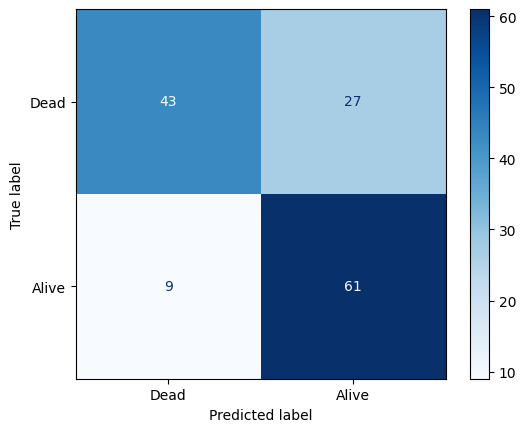

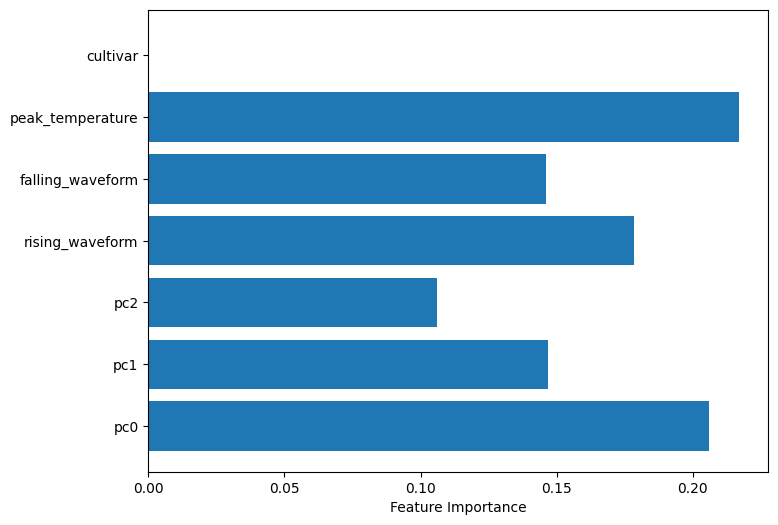

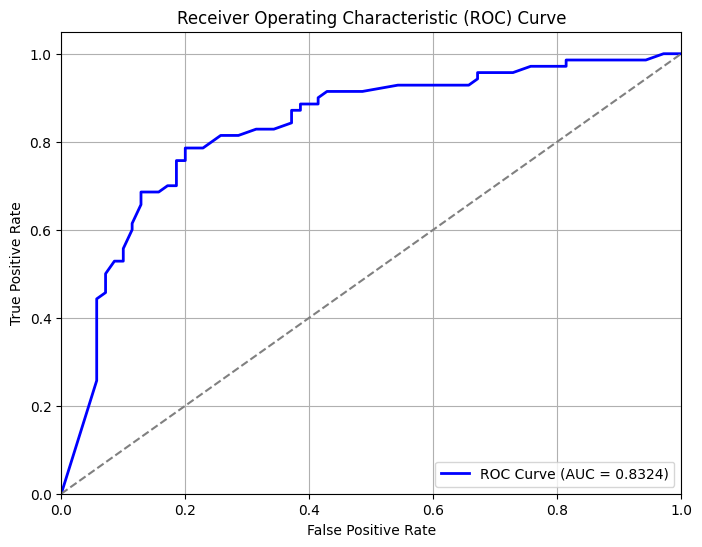

In [9]:
print('Random Forest for PN-Data without tuning')
run_model(X_train, y_train, X_test, y_test)

Accuracy: 0.75
F1 Score: 0.7770700636942676
Precision: 0.7011494252873564
Recall: 0.8714285714285714
AUC-ROC: 0.75
------------------------------------
Cross-Validation Accuracy Scores: 0.7755102040816326
Cross-Validation F1 Scores: 0.843097930941314
Cross-Validation Precision Scores: 0.8121643194919056
Cross-Validation Recall Scores: 0.8765432098765432
Cross-Validation ROC-AUC Scores: 0.7142278890912771


<Figure size 600x600 with 0 Axes>

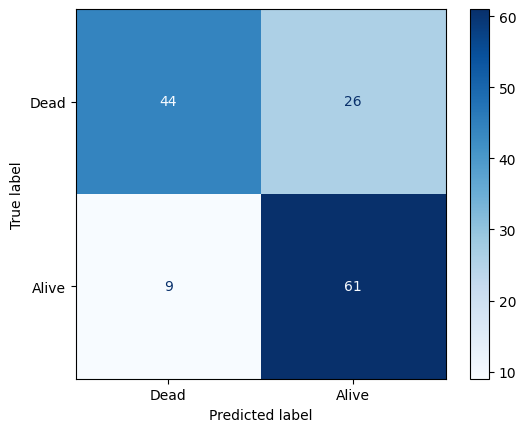

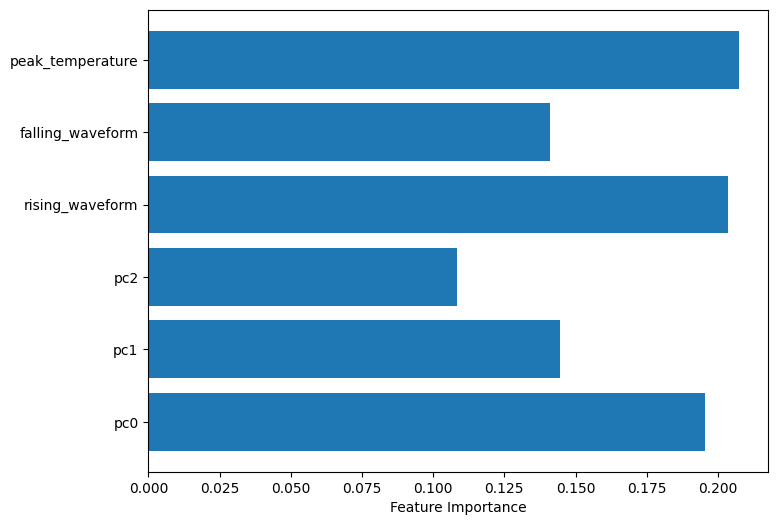

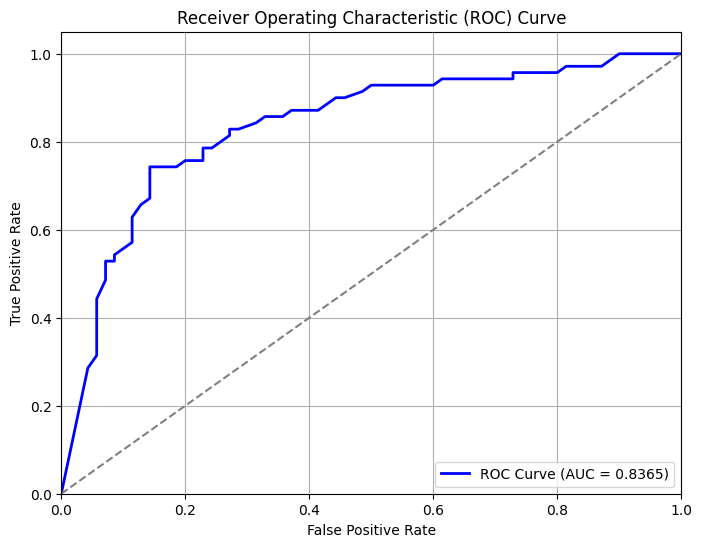

In [10]:
# throw the cultivar feature away and run the model again
X_train = X_train.drop(columns=['cultivar'])
X_test = X_test.drop(columns=['cultivar'])
run_model(X_train, y_train, X_test, y_test)

In [11]:
# # Create a DataFrame for storing ROC data
# roc_df = pd.DataFrame({"FPR": fpr, "TPR": tpr})
# roc_df["Model"] = "Random Forest"
# roc_df["AUC"] = roc_auc  # Store AUC score as a column

# Save to CSV (appending if file exists)
# roc_df.to_csv("roc_comparison.csv", mode='a', index=False, header=not pd.io.common.file_exists("roc_comparison.csv"))
